# Pattern Recognition and Machine Learning Bonus Project



##Personality Prediction using Myers Briggs Type Indicator
Siddharth Singh (B20EE067)

# Importing Necessary Libraries

In [ ]:
import pandas as pd
import re
import plotly.express as graph
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from tqdm import tqdm
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from bokeh.io import output_file, show
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,roc_curve,roc_auc_score
from nltk.stem.porter import PorterStemmer 
from nltk.tokenize import word_tokenize
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
import string
import nltk as nl
stemmer=PorterStemmer()
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing and Visualization

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/mbti_1.csv")
df.head()

type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

In [ ]:
#Description about data
print("Dataset Description: \n", df.describe())
print("\n")
#Info about data
print("Datset Info: \n", df.info())
print("\n")

#Shape data
print("Dimensions of Dataset: ",df.shape)
print("\n\n")

Dataset Description: 
         type                                              posts
count   8675                                               8675
unique    16                                               8675
top     INFP  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq    1832                                                  1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB
Datset Info: 
 None


Dimensions of Dataset:  (8675, 2)





In [ ]:
graph.pie(df,names='type',title='Pie graph for types of mbti personality in the data', height=600, width=600)

AxesSubplot(0.125,0.125;0.775x0.755)


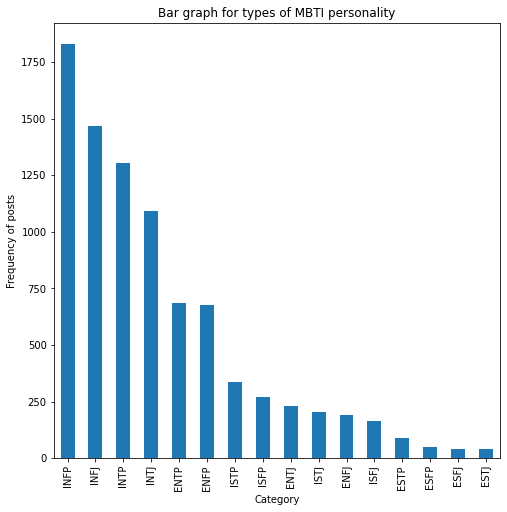

In [ ]:
CountCategory=df.type.value_counts()
print(CountCategory.plot(kind='bar',figsize=(8,8),xlabel='Category',ylabel='Frequency of posts', title='Bar graph for types of MBTI personality'))

In [ ]:
def helper(ch1, Type, ind):
  l = []
  for j in Type:
    if j[ind]==ch1:
      l.append(1)
    else :
      l.append(0)
  return l

Type= list(df["type"])
IE = helper('I',Type,0) # 1: Introversion(I),  0: Extroversion(E)
NS = helper('N',Type,1) # 1: Intuition(N), 0: Sensing(S)
TF = helper('T',Type,2) # 1: Thinking(T), 0: Feeling(F)
JP = helper('J',Type,3) # 1: Judging(J), 0: Perceiving(P)

df['IE'] = IE
df['NS'] = NS
df['TF'] = TF
df['JP'] = JP

df['posts'] = df['posts'].str.lower()
df.head()

type                                              posts  IE  NS  TF  JP
0  INFJ  'http://www.youtube.com/watch?v=qsxhcwe3krw|||...   1   1   0   1
1  ENTP  'i'm finding the lack of me in these posts ver...   0   1   1   0
2  INTP  'good one  _____   https://www.youtube.com/wat...   1   1   1   0
3  INTJ  'dear intp,   i enjoyed our conversation the o...   1   1   1   1
4  ENTJ  'you're fired.|||that's another silly misconce...   0   1   1   1

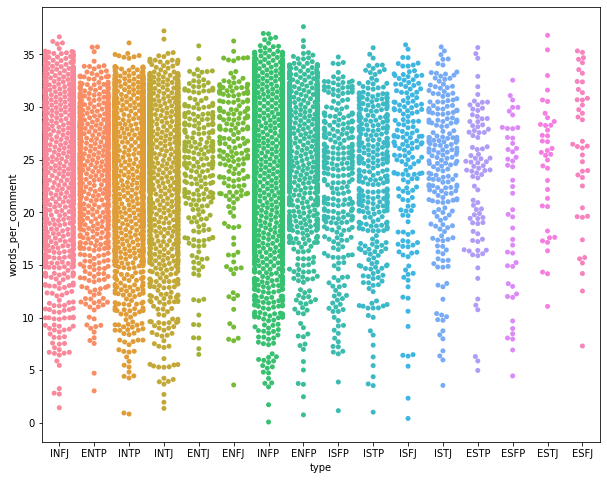

In [ ]:
# Swarm Plot
df1 = df.copy()
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

#this function counts the no of words per post out of the total 50 posts in the whole row
df1['words_per_comment'] = df1['posts'].apply(lambda x: len(x.split())/50)
df1['variance_of_word_counts'] = df1['posts'].apply(lambda x: var_row(x))

plt.figure(figsize=(10,8))
sns.swarmplot("type", "words_per_comment", data=df1)

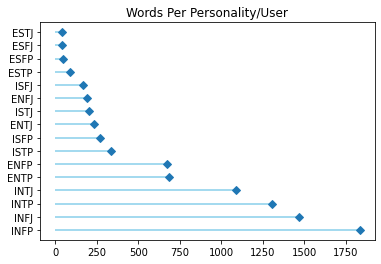

In [ ]:
dist = df['type'].value_counts()
plt.hlines(y=list(range(16)), xmin=0, xmax=dist, color='skyblue')
plt.plot(dist, list(range(16)), "D")
plt.title("Words Per Personality/User")
plt.yticks(list(range(16)), dist.index)
plt.show()

AxesSubplot(0.125,0.125;0.62x0.755)


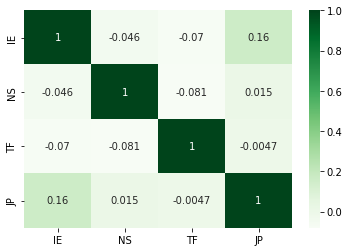

In [ ]:
columns=['IE','NS','TF','JP']
matrix=df1[columns].corr()
print(sns.heatmap(matrix,annot=True,cmap='Greens'))

In [ ]:
def preprocessing(i):

    """
    This function takes a list of texual data as input.
    It performs pre-processing and natural language processing on the data.
    It returns the processed textual data list as output.
    """
    
    #remove url links
    post_temp=df['posts'][i]
    pattern = re.compile(r'https?://[a-zA-Z0-9./-]*/[a-zA-Z0-9?=_.]*[_0-9.a-zA-Z/-]*')
    post_temp= re.sub(pattern, ' ', post_temp)
    
    
    #removing special characters and numbers from texts.
    pattern = re.compile(r'[\W+0-9_+\s]')
    post_temp= re.sub(pattern, ' ', post_temp)
    
    #removing extra spaces from texts.
    pattern = re.compile(r'\s+')
    post_temp= re.sub(pattern, ' ', post_temp)
    
    
    #remove stop words
    remove_words = stopwords.words("english")
    post_temp=" ".join([w for w in post_temp.split(' ') if w not in remove_words])
    
    #remove mbti personality words from text
    y = df['type'].to_list()
    mbti_words =  [i.lower() for i in np.unique(y)]
    mbti_words =  [i.lower() for i in np.unique(y)]
    post_temp=" ".join([w for w in post_temp.split(' ') if w not in mbti_words])
    
    #Lemmatization (grouping similar words)
    lemmatizer = WordNetLemmatizer()
    post_temp = " ".join([lemmatizer.lemmatize(i) for i in post_temp.split(' ')])

    return post_temp

for i in range(df.shape[0]):
     b = preprocessing(i)
     df['posts'][i] = b

In [ ]:
def get_top_n_imp_words(corpus,full_corpus,n=15):
    
    vec = TfidfVectorizer().fit(full_corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

imp_words_dict = {}
for personality in tqdm(df['type'].unique()):
    personality_data = df[df['type'] == personality]
    imp_words = get_top_n_imp_words(personality_data['posts'],df['posts'])
    imp_words_dict[personality] = imp_words

100%|██████████| 16/16 [01:11<00:00,  4.48s/it]


In [ ]:
from wordcloud import WordCloud, STOPWORDS
remove_words = stopwords.words("english")
def show_type_properties(types):
  extracted_data=df[df['type']==types]
  texts=" ".join(extracted_data['posts'].tolist())
  worldcount=WordCloud(background_color="white", max_words=100,
                   stopwords=remove_words, contour_width=3)
  worldcount.generate(texts)
  #Plot
  plt.figure(figsize=[20,6])
  plt.subplot(121)
  plt.imshow(worldcount, interpolation='bilinear')
  plt.axis("off")
  plt.subplot(122)
  tuples = imp_words_dict[types]
  words = [x[0] for x in tuples]
  imp = [x[1] for x in tuples]
  sns.barplot(y = words,x = imp)
  plt.title(f'Important Words for {types}')
  plt.xlabel('Importance - tfidf value')

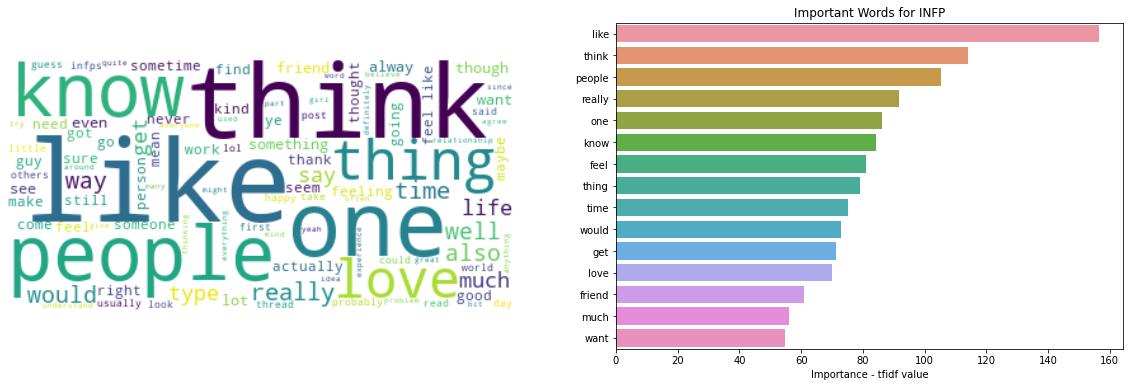

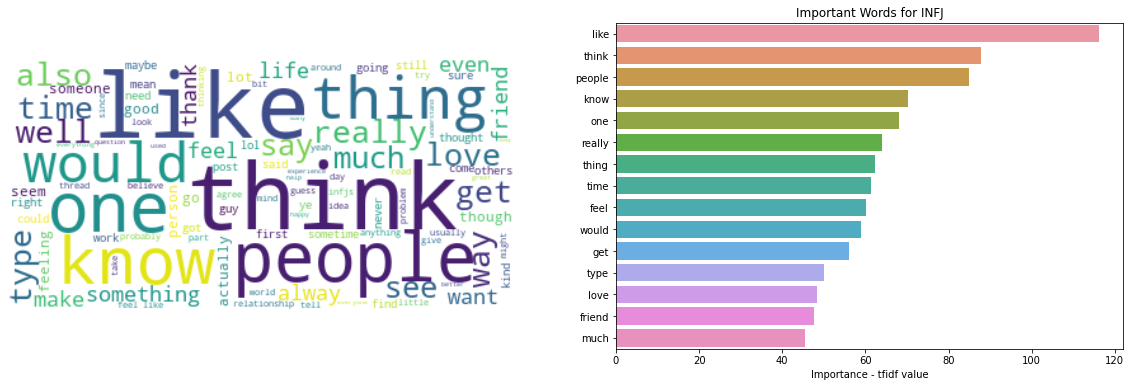

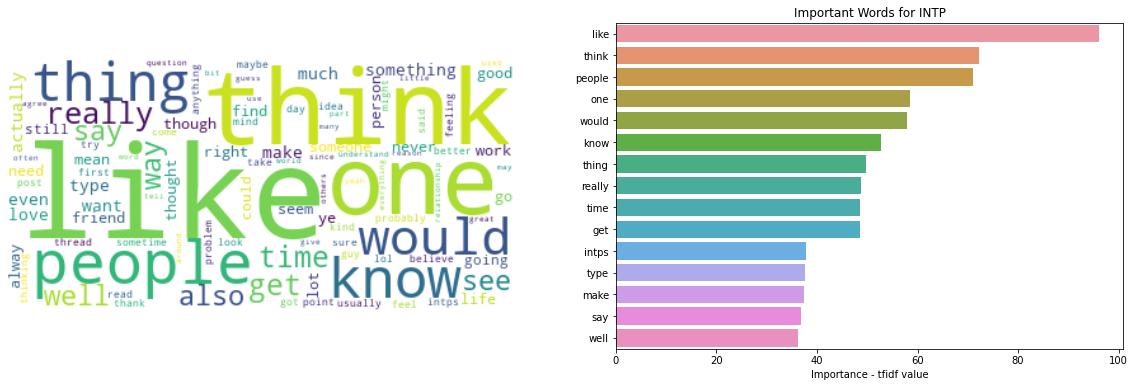

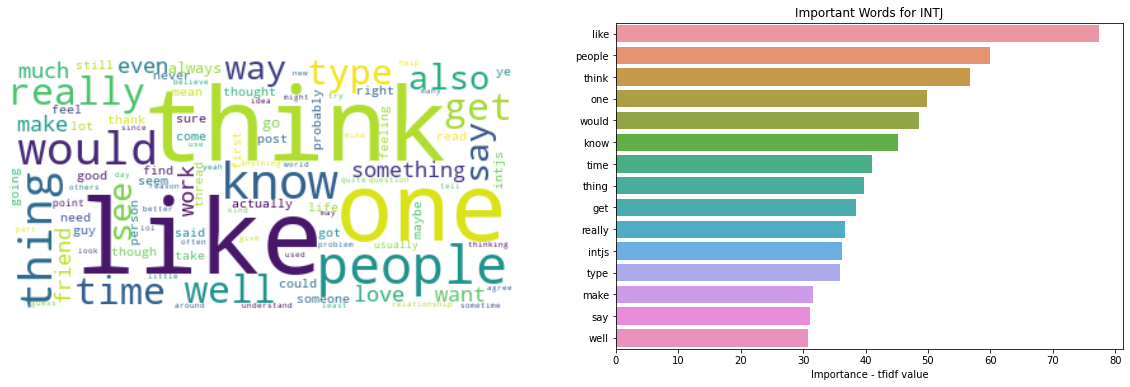

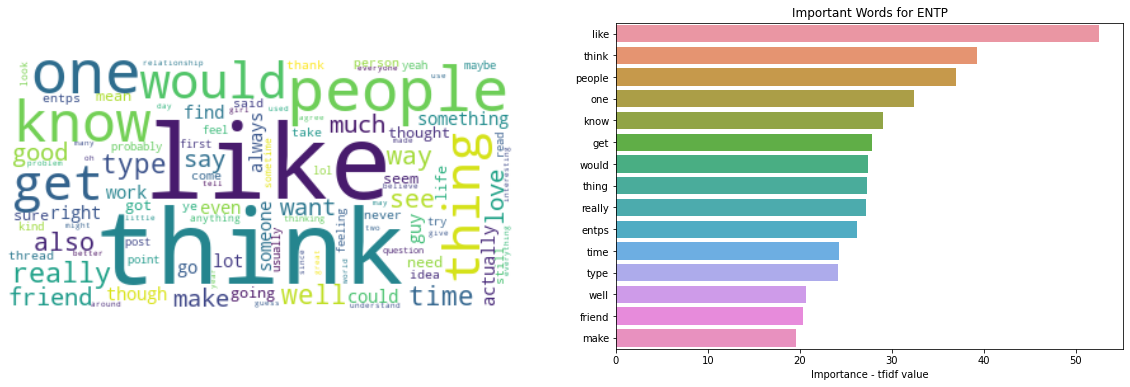

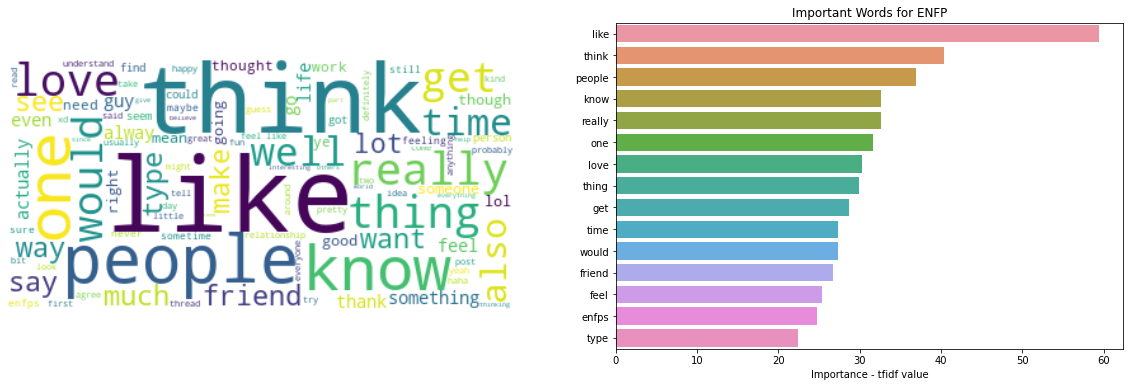

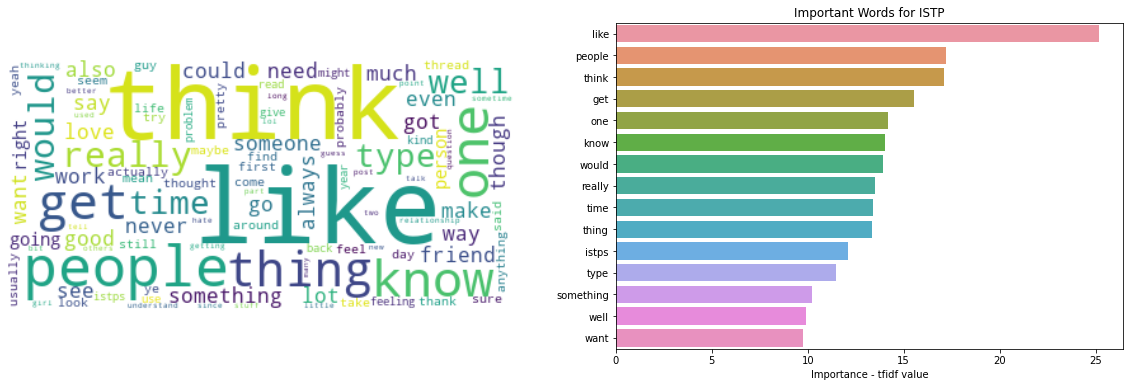

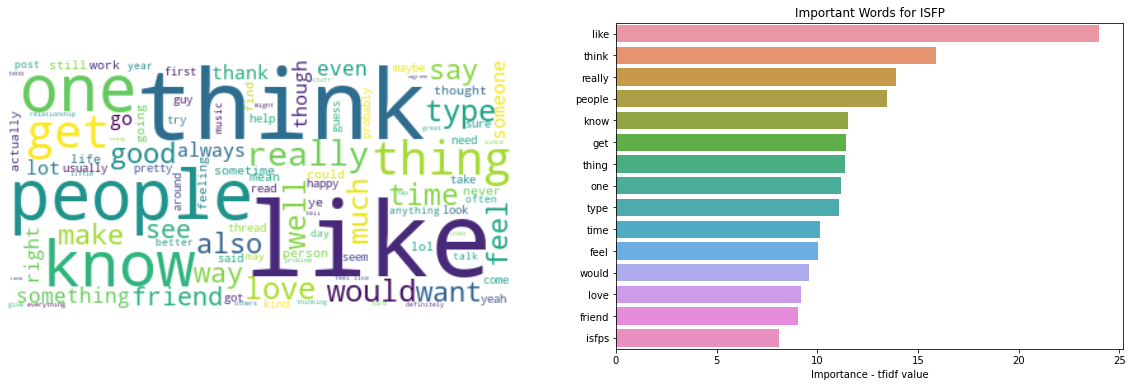

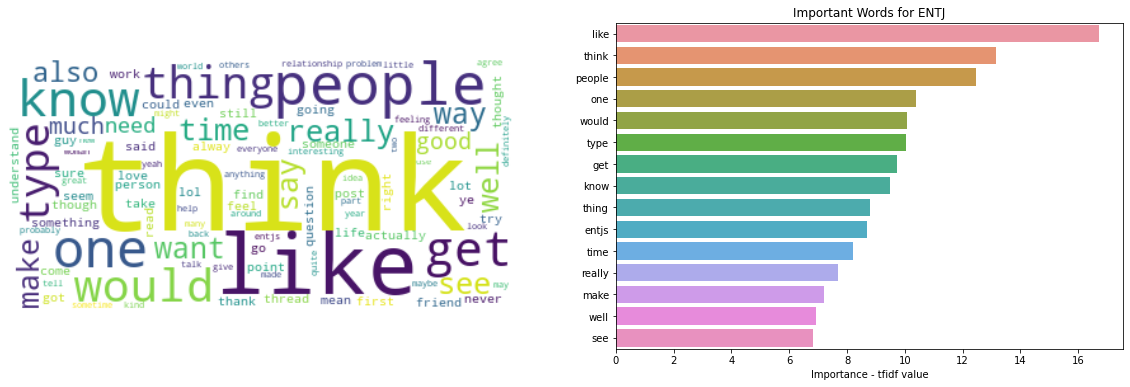

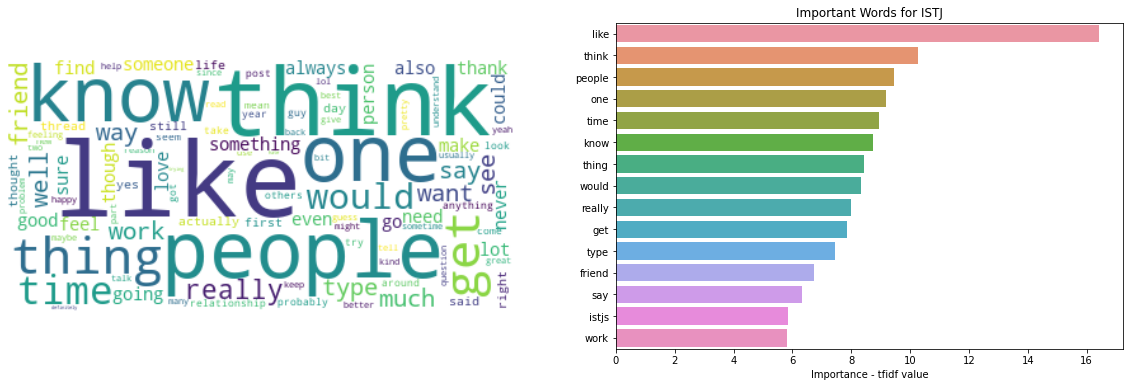

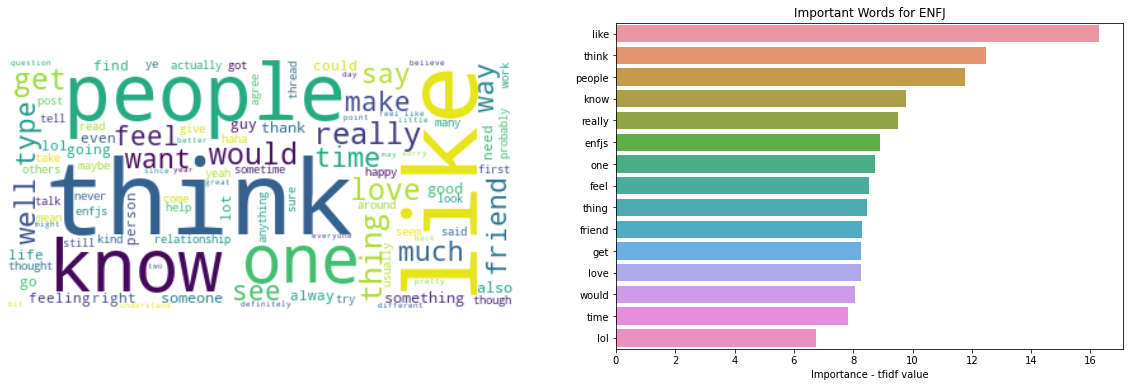

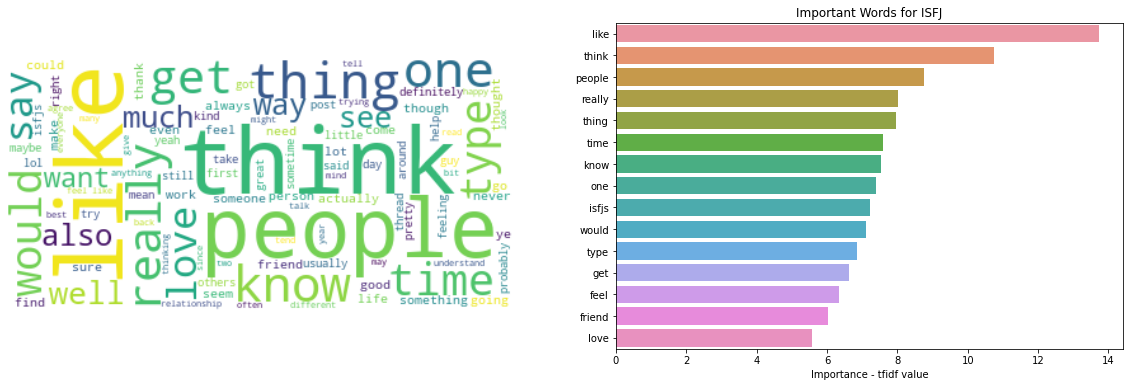

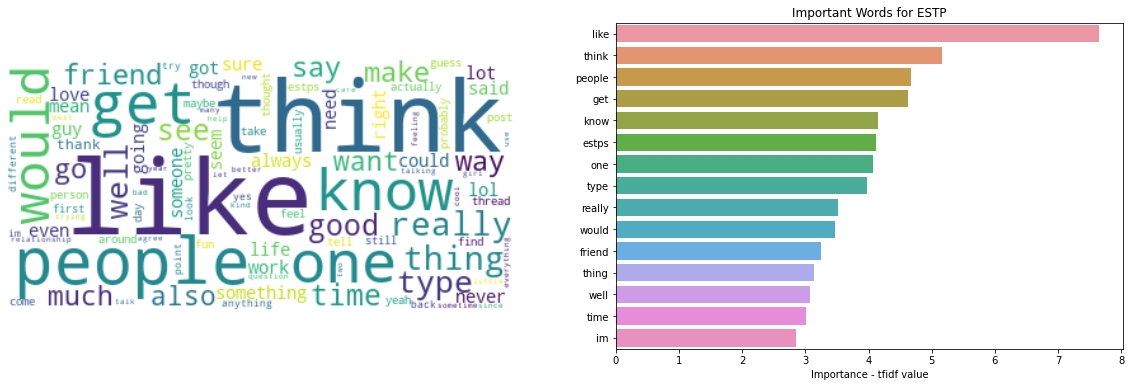

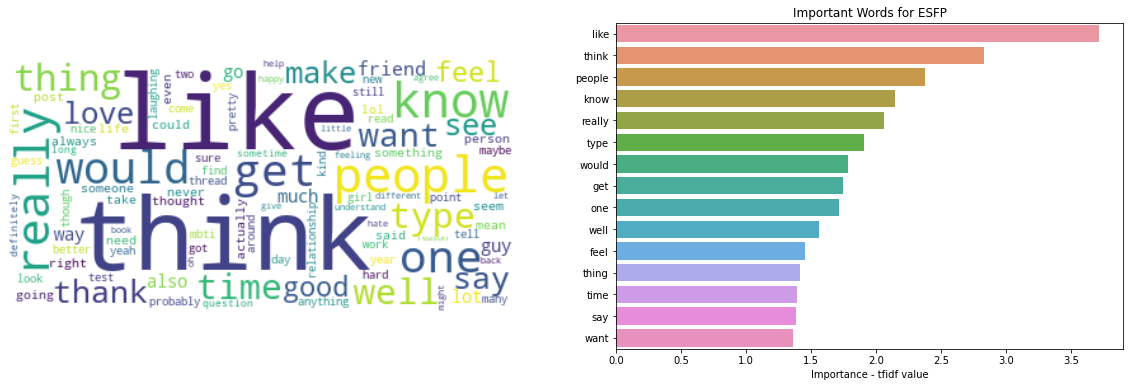

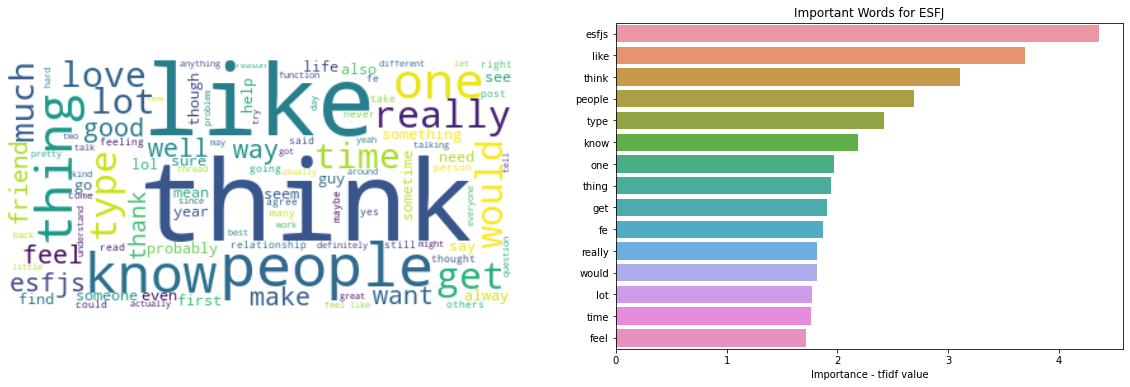

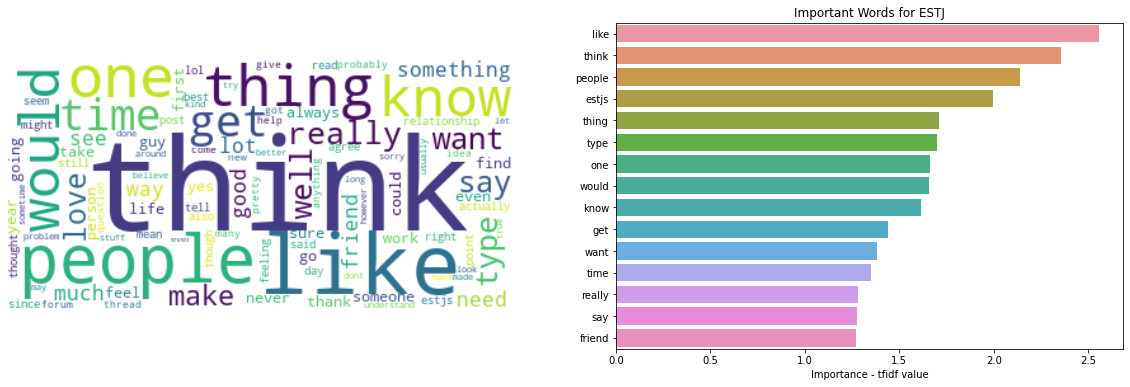

In [ ]:
CountCategory=df.type.value_counts()
for i in CountCategory.index:
  show_type_properties(i)

In [ ]:
#Finding features using CountVectorizer by converting the posts into matrix of word count
p_list=[]
for i,j in df.posts.iteritems():
  p_list.append(j)

vector=CountVectorizer(stop_words='english',max_features=1500)
features=vector.fit_transform(p_list)

#tf-idf to weigh the importance of words(features) across all posts and select more relevent features
transform = TfidfTransformer()
finalfeatures =  transform.fit_transform(features).toarray()

del df['type']

In [ ]:
X_data=finalfeatures
Y_data= df.iloc[:,1:5]

X_train_IE, X_test_IE, Y_train_IE, Y_test_IE = train_test_split(X_data, Y_data['IE'], test_size=0.2, random_state=123,stratify=Y_data)
X_train_NS, X_test_NS, Y_train_NS, Y_test_NS = train_test_split(X_data, Y_data['NS'], test_size=0.2, random_state=123,stratify=Y_data)
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = train_test_split(X_data, Y_data['TF'], test_size=0.2, random_state=123,stratify=Y_data)
X_train_JP, X_test_JP, Y_train_JP, Y_test_JP = train_test_split(X_data, Y_data['JP'], test_size=0.2, random_state=123,stratify=Y_data)

# Helper Functions for Training, Testing and Visualization of Results

In [ ]:
def plot_confusion(com,title,category,colour): 
  group_names = ['True Neg','False Pos','False Neg','True Pos']

  group_counts = ["{0:0.0f}".format(value) for value in com.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in com.flatten()/np.sum(com)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)
  ax = sns.heatmap(com, annot=labels, fmt='', cmap=colour)
  ax.set_title(title+"\n",size=13,fontweight='bold');
  ax.set_xlabel('\nPredicted Personality')
  ax.set_ylabel('Actual Personality ');
  ax.xaxis.set_ticklabels([category[0],category[1]])
  ax.yaxis.set_ticklabels([category[0],category[1]])
  plt.show()
  print("\n|==================================================================================|\n")

In [ ]:
def print_roc_auc_curve(probIE, probNS, probTF, probJP):
  
  fp_IE, tp_IE, val = roc_curve(Y_test_IE, probIE[:,1])
  fp_NS, tp_NS, val = roc_curve(Y_test_NS, probNS[:,1])
  fp_TF, tp_TF, val = roc_curve(Y_test_TF, probTF[:,1])
  fp_JP, tp_JP, val = roc_curve(Y_test_JP, probJP[:,1])

  auc_IE = round(roc_auc_score(Y_test_IE, probIE[:,1]),3)
  auc_NS = round(roc_auc_score(Y_test_NS, probNS[:,1]),3)
  auc_TF = round(roc_auc_score(Y_test_TF, probTF[:,1]),3)
  auc_JP = round(roc_auc_score(Y_test_JP, probJP[:,1]),3)
  
  plt.figure(figsize=(8,6))
  plt.plot(fp_IE, tp_IE, color='red', label='Extroversion(E) / Introversion(I) (AUC Score: '+str(auc_IE)+')')
  plt.plot(fp_NS, tp_NS, color='blue', label='Sensing(S) / Intuition(N) (AUC Score: '+str(auc_NS)+')')
  plt.plot(fp_TF, tp_TF, color='orange', label='Feeling(F) / Thinking(T) (AUC Score: '+str(auc_TF)+')')
  plt.plot(fp_JP, tp_JP, color='green', label='Perceiving(P) / Judging(J) (AUC Score: '+str(auc_JP)+')')
  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlabel('False Positive Rate',size=13,fontweight='bold')
  plt.ylabel('True Positive Rate',size=13,fontweight='bold')
  plt.title('ROC Curve',size=15,fontweight='bold')
  plt.legend(loc='best')
  plt.show()

In [ ]:
def training_testing(model,x_train,x_test,y_train,y_test,labels,colour):
  
  l1,l2 = labels[0],labels[1]
  model1 = model
  best_grid = GridSearchCV(model,{},cv=5)
  p = best_grid.fit(x_train,y_train)
  pred = p.best_estimator_.predict(x_test)
  acc = accuracy_score(y_test,pred)
  com = confusion_matrix(y_test,pred)
  print("Accuracy for "+l1 + " / " +l2+": ", acc, "\n")
  print("Classification Report for "+l1 + " / " +l2+": \n")
  title =  "confusion matrix for "+l1 + " / " +l2+": "
  
  print(classification_report(y_test,pred,target_names=labels))
  plot_confusion(com,title,labels,colour)
 
  return p.best_estimator_.predict_proba(x_test)

In [ ]:
def model_training(model):

  labels_IE = ["Extroversion(E)","Introversion(I)"]
  p1_IE = training_testing(model,X_train_IE,X_test_IE,Y_train_IE,Y_test_IE,labels_IE,"Blues")

  labels_NS = ["Sensing(S)","Intuition(N)"]
  p2_NS = training_testing(model,X_train_NS,X_test_NS,Y_train_NS,Y_test_NS,labels_NS,"YlGnBu")

  labels_TF = [ "Feeling(F)","Thinking(T)"]
  p3_TF = training_testing(model,X_train_TF,X_test_TF,Y_train_TF,Y_test_TF,labels_TF,"Greens")

  labels_JP = ["Perceiving(P)","Judging(J)"]
  p4_JP = training_testing(model,X_train_JP,X_test_JP,Y_train_JP,Y_test_JP,labels_JP,"BuPu")

  print_roc_auc_curve(p1_IE, p2_NS, p3_TF, p4_JP)

# Logistic Regression

Without Linear Discriminant Analysis (LDA)

Accuracy for Extroversion(E) / Introversion(I):  0.8115273775216139 

Classification Report for Extroversion(E) / Introversion(I): 

                 precision    recall  f1-score   support

Extroversion(E)       0.76      0.27      0.40       401
Introversion(I)       0.82      0.98      0.89      1334

       accuracy                           0.81      1735
      macro avg       0.79      0.62      0.64      1735
   weighted avg       0.80      0.81      0.77      1735



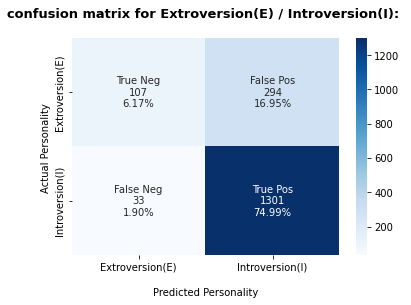


|==================================================================================|

Accuracy for Sensing(S) / Intuition(N):  0.8674351585014409 

Classification Report for Sensing(S) / Intuition(N): 

              precision    recall  f1-score   support

  Sensing(S)       0.78      0.06      0.11       240
Intuition(N)       0.87      1.00      0.93      1495

    accuracy                           0.87      1735
   macro avg       0.82      0.53      0.52      1735
weighted avg       0.86      0.87      0.81      1735



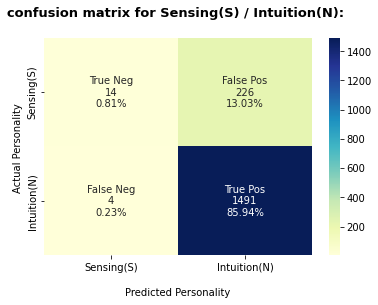


|==================================================================================|

Accuracy for Feeling(F) / Thinking(T):  0.805763688760807 

Classification Report for Feeling(F) / Thinking(T): 

              precision    recall  f1-score   support

  Feeling(F)       0.81      0.84      0.82       939
 Thinking(T)       0.80      0.77      0.78       796

    accuracy                           0.81      1735
   macro avg       0.81      0.80      0.80      1735
weighted avg       0.81      0.81      0.81      1735



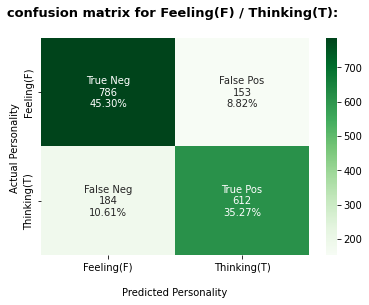


|==================================================================================|

Accuracy for Perceiving(P) / Judging(J):  0.7221902017291066 

Classification Report for Perceiving(P) / Judging(J): 

               precision    recall  f1-score   support

Perceiving(P)       0.73      0.87      0.79      1048
   Judging(J)       0.71      0.50      0.59       687

     accuracy                           0.72      1735
    macro avg       0.72      0.68      0.69      1735
 weighted avg       0.72      0.72      0.71      1735



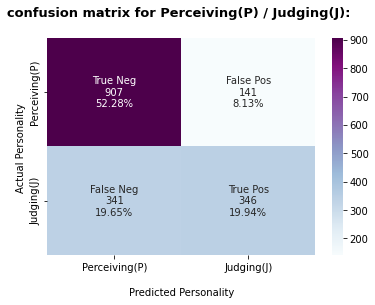


|==================================================================================|



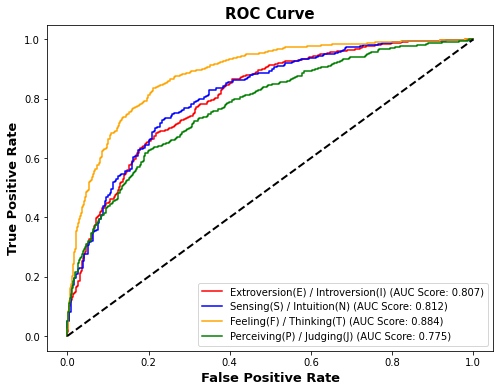

In [ ]:
model_training(LogisticRegression())

With Linear Discriminant Analysis (LDA)

Accuracy for Introversion(I)/Extroversion(E): 86.9 %

Classification Report for Introversion(I)/Extroversion(E):  

                 precision    recall  f1-score   support

Extroversion(E)       0.78      0.61      0.68       401
Introversion(I)       0.89      0.95      0.92      1334

       accuracy                           0.87      1735
      macro avg       0.83      0.78      0.80      1735
   weighted avg       0.86      0.87      0.86      1735



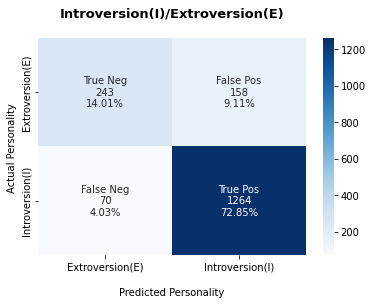


|==================================================================================|



In [ ]:
X2_data=finalfeatures
lda = LinearDiscriminantAnalysis()
lda.fit(X2_data,Y_data['IE'])
X2_data = lda.transform(X2_data)
X1_train_IE, X1_test_IE, Y1_train_IE, Y1_test_IE = train_test_split(X2_data, Y_data['IE'], test_size=0.2, random_state=123,stratify=Y_data)
model = LogisticRegression()
model.fit(X1_train_IE,Y1_train_IE)
pred = model.predict(X1_test_IE)
com = confusion_matrix(Y1_test_IE,pred)
lpIe = model.predict_proba(X1_test_IE)
acc = round(accuracy_score(Y1_test_IE,pred),3)
print("Accuracy for Introversion(I)/Extroversion(E):" , 100*acc,"%\n")
print("Classification Report for Introversion(I)/Extroversion(E): ", "\n")
print(classification_report(Y1_test_IE,pred,target_names = ["Extroversion(E)","Introversion(I)"]))
plot_confusion(com,"Introversion(I)/Extroversion(E)",["Extroversion(E)","Introversion(I)"],colour="Blues")

Accuracy for Intuition(N) / Sensing(S):  91.5 %

Classification Report for Intuition(N) / Sensing(S):  

              precision    recall  f1-score   support

  Sensing(S)       0.79      0.53      0.63       240
Intuition(N)       0.93      0.98      0.95      1495

    accuracy                           0.92      1735
   macro avg       0.86      0.75      0.79      1735
weighted avg       0.91      0.92      0.91      1735



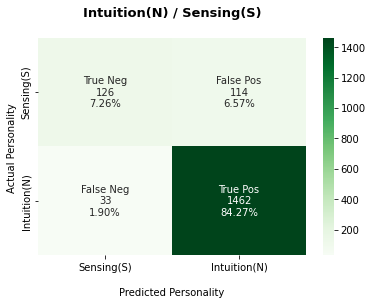


|==================================================================================|



In [ ]:
X2_data=finalfeatures
lda = LinearDiscriminantAnalysis()
lda.fit(X2_data,Y_data['NS'])
X2_data = lda.transform(X2_data)
X1_train_NS, X1_test_NS, Y1_train_NS, Y1_test_NS = train_test_split(X2_data, Y_data['NS'], test_size=0.2, random_state=123,stratify=Y_data)
model = LogisticRegression()
model.fit(X1_train_NS,Y1_train_NS)
pred = model.predict(X1_test_NS)
lpIs = model.predict_proba(X1_test_NS)
com = confusion_matrix(Y1_test_NS,pred)
acc = round(accuracy_score(Y1_test_NS,pred),3)
print("Accuracy for Intuition(N) / Sensing(S): " , 100*acc,"%\n")
print("Classification Report for Intuition(N) / Sensing(S): ", "\n")
print(classification_report(Y1_test_NS,pred,target_names = ["Sensing(S)","Intuition(N)"]))
plot_confusion(com,"Intuition(N) / Sensing(S)",["Sensing(S)","Intuition(N)"],colour="Greens")

Accuracy for Thinking(T), Feeling(F):  86.2 %

Classification Report for Thinking(T), Feeling(F):  

              precision    recall  f1-score   support

  Feeling(F)       0.87      0.88      0.87       939
 Thinking(T)       0.85      0.84      0.85       796

    accuracy                           0.86      1735
   macro avg       0.86      0.86      0.86      1735
weighted avg       0.86      0.86      0.86      1735



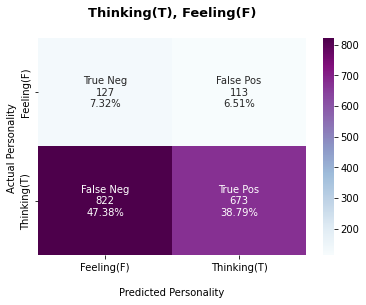


|==================================================================================|



In [ ]:
X2_data=finalfeatures
lda = LinearDiscriminantAnalysis()
lda.fit(X2_data,Y_data['TF'])
X2_data = lda.transform(X2_data)
X1_train_TF, X1_test_TF, Y1_train_TF, Y1_test_TF = train_test_split(X2_data, Y_data['TF'], test_size=0.2, random_state=123,stratify=Y_data)
model = LogisticRegression()
model.fit(X1_train_TF,Y1_train_TF)
pred = model.predict(X1_test_TF)
lpTF = model.predict_proba(X1_test_TF)
com = confusion_matrix(Y1_test_NS,pred)
acc = round(accuracy_score(Y1_test_TF,pred),3)
print("Accuracy for Thinking(T), Feeling(F): " , 100*acc,"%\n")
print("Classification Report for Thinking(T), Feeling(F): ", "\n")
print(classification_report(Y1_test_TF,pred,target_names = ["Feeling(F)","Thinking(T)"]))
plot_confusion(com,"Thinking(T), Feeling(F)",["Feeling(F)","Thinking(T)"],colour="BuPu")

Accuracy for Judging(J), Perceiving(P):  79.5 %

Classification Report for Judging(J), Perceiving(P):  

               precision    recall  f1-score   support

Perceiving(P)       0.81      0.86      0.83      1048
   Judging(J)       0.76      0.70      0.73       687

     accuracy                           0.79      1735
    macro avg       0.79      0.78      0.78      1735
 weighted avg       0.79      0.79      0.79      1735



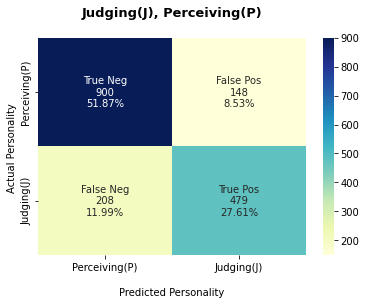


|==================================================================================|



In [ ]:
X2_data=finalfeatures
lda = LinearDiscriminantAnalysis()
lda.fit(X2_data,Y_data['JP'])
X2_data = lda.transform(X2_data)
X1_train_JP, X1_test_JP, Y1_train_JP, Y1_test_JP = train_test_split(X2_data, Y_data['JP'], test_size=0.2, random_state=123,stratify=Y_data)
model = LogisticRegression()
model.fit(X1_train_JP,Y1_train_JP)
pred = model.predict(X1_test_JP)
lpJP = model.predict_proba(X1_test_JP)
com = confusion_matrix(Y1_test_JP,pred)
acc = round(accuracy_score(Y1_test_JP,pred),3)
print("Accuracy for Judging(J), Perceiving(P): " , 100*acc,"%\n")
print("Classification Report for Judging(J), Perceiving(P): ", "\n")
print(classification_report(Y1_test_JP,pred,target_names=["Perceiving(P)","Judging(J)"]))
plot_confusion(com,"Judging(J), Perceiving(P)",["Perceiving(P)","Judging(J)"],colour="YlGnBu")

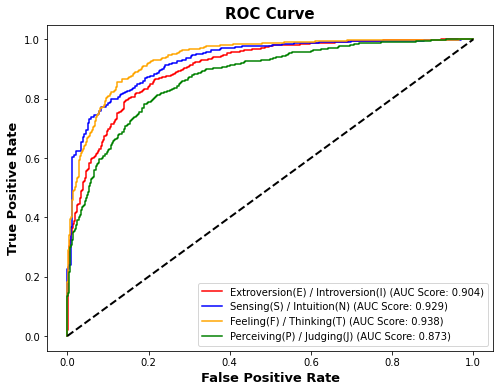

In [ ]:
print_roc_auc_curve(lpIe, lpIs, lpTF, lpJP)

# Support Vector Machine (SVM)

Accuracy for Extroversion(E) / Introversion(I):  0.8023054755043227 

Classification Report for Extroversion(E) / Introversion(I): 

                 precision    recall  f1-score   support

Extroversion(E)       0.77      0.21      0.33       401
Introversion(I)       0.80      0.98      0.88      1334

       accuracy                           0.80      1735
      macro avg       0.79      0.59      0.61      1735
   weighted avg       0.80      0.80      0.76      1735



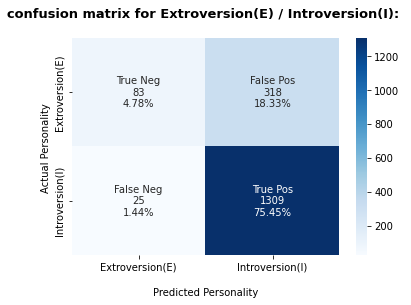


|==================================================================================|

Accuracy for Sensing(S) / Intuition(N):  0.8662824207492795 

Classification Report for Sensing(S) / Intuition(N): 

              precision    recall  f1-score   support

  Sensing(S)       0.79      0.05      0.09       240
Intuition(N)       0.87      1.00      0.93      1495

    accuracy                           0.87      1735
   macro avg       0.83      0.52      0.51      1735
weighted avg       0.86      0.87      0.81      1735



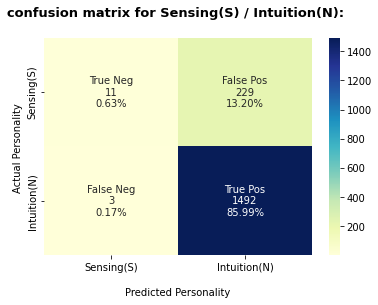


|==================================================================================|

Accuracy for Feeling(F) / Thinking(T):  0.8011527377521613 

Classification Report for Feeling(F) / Thinking(T): 

              precision    recall  f1-score   support

  Feeling(F)       0.81      0.83      0.82       939
 Thinking(T)       0.79      0.77      0.78       796

    accuracy                           0.80      1735
   macro avg       0.80      0.80      0.80      1735
weighted avg       0.80      0.80      0.80      1735



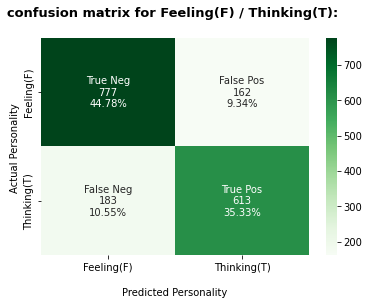


|==================================================================================|

Accuracy for Perceiving(P) / Judging(J):  0.7210374639769452 

Classification Report for Perceiving(P) / Judging(J): 

               precision    recall  f1-score   support

Perceiving(P)       0.72      0.88      0.79      1048
   Judging(J)       0.72      0.48      0.58       687

     accuracy                           0.72      1735
    macro avg       0.72      0.68      0.68      1735
 weighted avg       0.72      0.72      0.71      1735



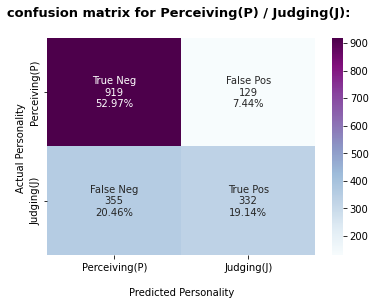


|==================================================================================|



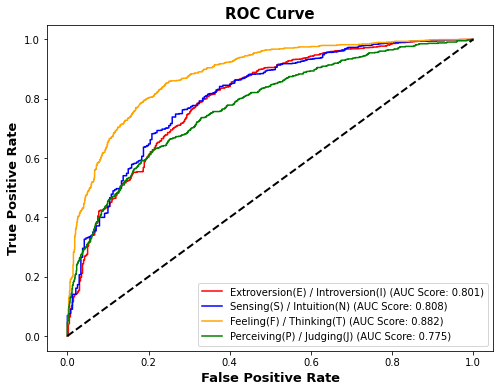

In [ ]:
model_training(svm.SVC(kernel = 'rbf',probability=True))

# XGBoost 

Finding the best max_depth for avoiding overfit

In [ ]:
def check(model_name,x_train,x_test,y_train,y_test,label):
  
  l = [i for i in range(3,15)]
  test_acc = []
  train_acc = []
  for i in l:
    m1 = xgb.XGBClassifier(max_depth = i)
    m1.fit(x_train,y_train)
    pred_test = m1.predict(x_test)
    pred_train = m1.predict(x_train)
    test_acc_1 = accuracy_score(y_test,pred_test)
    train_acc_1 = accuracy_score(y_train,pred_train)
    train_acc.append(train_acc_1)
    test_acc.append(test_acc_1)
  print("Accuracy vs Depth Graph for "+ label)
  print("\n")
  plt.plot(l, test_acc, marker='o', color='red', label='test')
  plt.plot(l, train_acc, marker='o', color='green', label='train')
  plt.xlabel('Depths')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title("Accuracy vs Depth Graph")
  plt.show()

Accuracy vs Depth Graph for Introversion(I) / Extroversion(E)




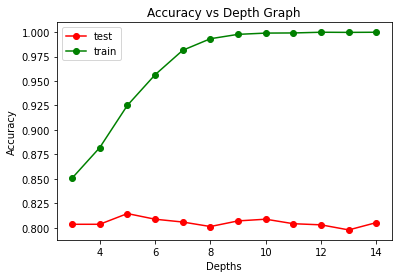



Accuracy vs Depth Graph for Intuition(N) / Sensing(S)




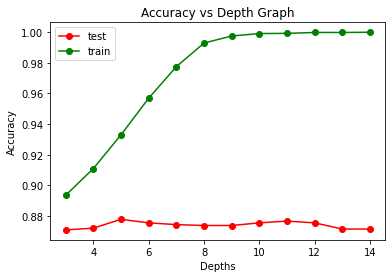



Accuracy vs Depth Graph for Thinking(T) / Feeling(F)




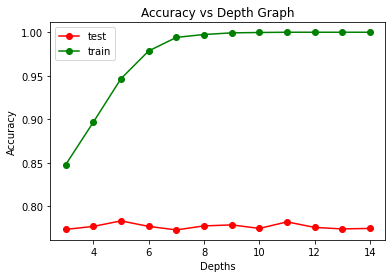



Accuracy vs Depth Graph for Judging(J) / Perceiving(P)




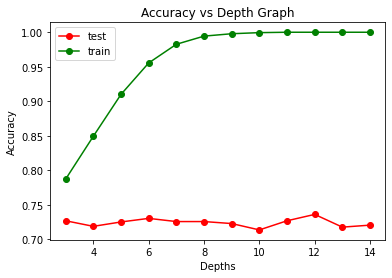

In [ ]:
check("XGBoost",X_train_IE,X_test_IE,Y_train_IE,Y_test_IE,"Introversion(I) / Extroversion(E)")
print("\n")
check("XGBoost",X_train_NS,X_test_NS,Y_train_NS,Y_test_NS,"Intuition(N) / Sensing(S)")
print("\n")
check("XGBoost",X_train_TF,X_test_TF,Y_train_TF,Y_test_TF,"Thinking(T) / Feeling(F)")
print("\n")
check("XGBoost",X_train_JP,X_test_JP,Y_train_JP,Y_test_JP,"Judging(J) / Perceiving(P)")
print("\n")

From the above plot we get max_depth = 5

Accuracy for Extroversion(E) / Introversion(I):  0.8144092219020173 

Classification Report for Extroversion(E) / Introversion(I): 

                 precision    recall  f1-score   support

Extroversion(E)       0.76      0.29      0.42       401
Introversion(I)       0.82      0.97      0.89      1334

       accuracy                           0.81      1735
      macro avg       0.79      0.63      0.65      1735
   weighted avg       0.81      0.81      0.78      1735



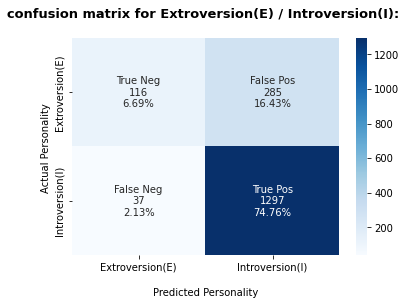


|==================================================================================|

Accuracy for Sensing(S) / Intuition(N):  0.8778097982708933 

Classification Report for Sensing(S) / Intuition(N): 

              precision    recall  f1-score   support

  Sensing(S)       0.80      0.15      0.26       240
Intuition(N)       0.88      0.99      0.93      1495

    accuracy                           0.88      1735
   macro avg       0.84      0.57      0.60      1735
weighted avg       0.87      0.88      0.84      1735



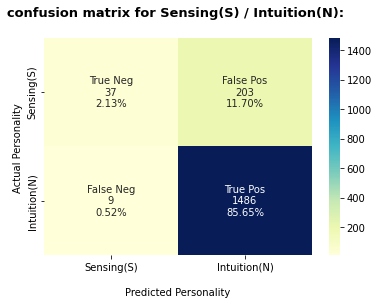


|==================================================================================|

Accuracy for Feeling(F) / Thinking(T):  0.7832853025936599 

Classification Report for Feeling(F) / Thinking(T): 

              precision    recall  f1-score   support

  Feeling(F)       0.80      0.81      0.80       939
 Thinking(T)       0.77      0.76      0.76       796

    accuracy                           0.78      1735
   macro avg       0.78      0.78      0.78      1735
weighted avg       0.78      0.78      0.78      1735



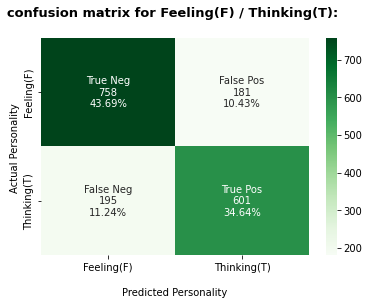


|==================================================================================|

Accuracy for Perceiving(P) / Judging(J):  0.72507204610951 

Classification Report for Perceiving(P) / Judging(J): 

               precision    recall  f1-score   support

Perceiving(P)       0.72      0.88      0.80      1048
   Judging(J)       0.73      0.48      0.58       687

     accuracy                           0.73      1735
    macro avg       0.73      0.68      0.69      1735
 weighted avg       0.73      0.73      0.71      1735



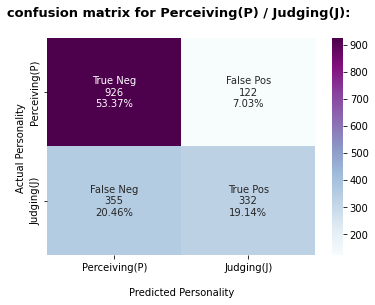


|==================================================================================|



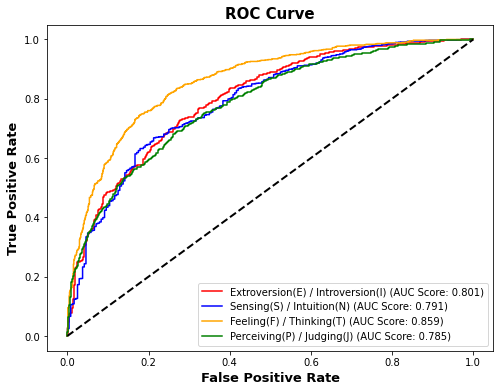

In [ ]:
model_training(xgb.XGBClassifier(max_depth = 5))

# Random Forest Classifier

In [ ]:
#Hyperparameter tuning for Random Forest Classifier
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_IE,Y_train_IE)
grid_search.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


{'max_depth': 100, 'n_estimators': 100}

Random Forest Classifier

Accuracy for Extroversion(E) / Introversion(I):  0.7723342939481268 

Classification Report for Extroversion(E) / Introversion(I): 

                 precision    recall  f1-score   support

Extroversion(E)       1.00      0.01      0.03       401
Introversion(I)       0.77      1.00      0.87      1334

       accuracy                           0.77      1735
      macro avg       0.89      0.51      0.45      1735
   weighted avg       0.82      0.77      0.68      1735



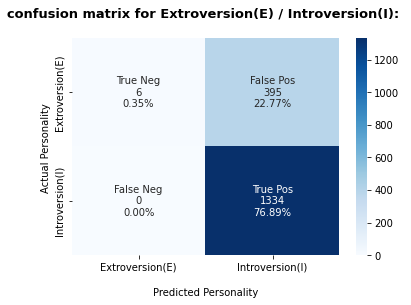


|==================================================================================|

Accuracy for Sensing(S) / Intuition(N):  0.8622478386167147 

Classification Report for Sensing(S) / Intuition(N): 

              precision    recall  f1-score   support

  Sensing(S)       1.00      0.00      0.01       240
Intuition(N)       0.86      1.00      0.93      1495

    accuracy                           0.86      1735
   macro avg       0.93      0.50      0.47      1735
weighted avg       0.88      0.86      0.80      1735



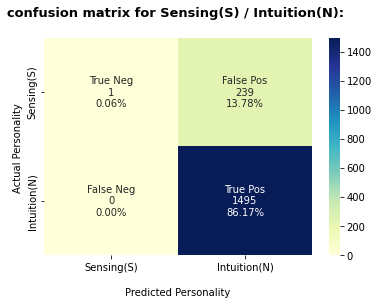


|==================================================================================|

Accuracy for Feeling(F) / Thinking(T):  0.7452449567723343 

Classification Report for Feeling(F) / Thinking(T): 

              precision    recall  f1-score   support

  Feeling(F)       0.74      0.81      0.78       939
 Thinking(T)       0.75      0.67      0.71       796

    accuracy                           0.75      1735
   macro avg       0.75      0.74      0.74      1735
weighted avg       0.75      0.75      0.74      1735



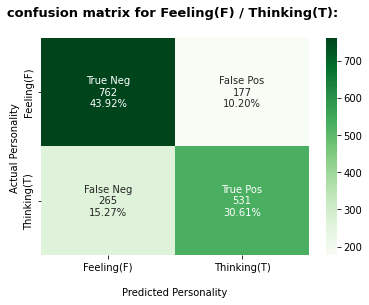


|==================================================================================|

Accuracy for Perceiving(P) / Judging(J):  0.659942363112392 

Classification Report for Perceiving(P) / Judging(J): 

               precision    recall  f1-score   support

Perceiving(P)       0.65      0.95      0.77      1048
   Judging(J)       0.75      0.21      0.33       687

     accuracy                           0.66      1735
    macro avg       0.70      0.58      0.55      1735
 weighted avg       0.69      0.66      0.60      1735



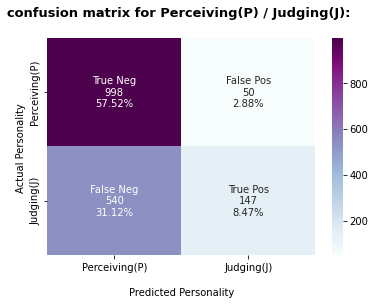


|==================================================================================|



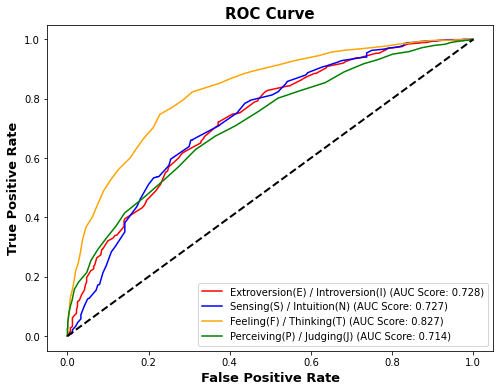

In [ ]:
model_training(RandomForestClassifier(max_depth = 100,n_estimators=100))

Random Forest Classifier with Linear Discriminant Analysis (LDA)

Accuracy for Introversion(I)/Extroversion(E): 81.69999999999999 %

Classification Report for Introversion(I)/Extroversion(E):  

                 precision    recall  f1-score   support

Extroversion(E)       0.61      0.58      0.59       401
Introversion(I)       0.88      0.89      0.88      1334

       accuracy                           0.82      1735
      macro avg       0.74      0.73      0.74      1735
   weighted avg       0.81      0.82      0.82      1735



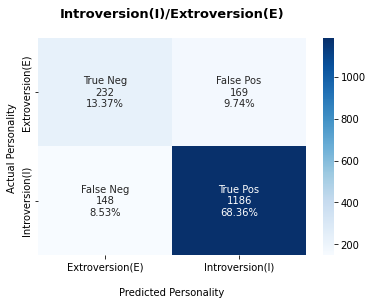


|==================================================================================|



In [ ]:
model = RandomForestClassifier(max_depth = 100,n_estimators=100)
model.fit(X1_train_IE,Y1_train_IE)
pred = model.predict(X1_test_IE)
com = confusion_matrix(Y1_test_IE,pred)
lpIe = model.predict_proba(X1_test_IE)
acc = round(accuracy_score(Y1_test_IE,pred),3)
print("Accuracy for Introversion(I)/Extroversion(E):" , 100*acc,"%\n")
print("Classification Report for Introversion(I)/Extroversion(E): ", "\n")
print(classification_report(Y1_test_IE,pred,target_names = ["Extroversion(E)","Introversion(I)"]))
plot_confusion(com,"Introversion(I)/Extroversion(E)",["Extroversion(E)","Introversion(I)"],colour="Blues")

Accuracy for Intuition(N) / Sensing(S):  87.0 %

Classification Report for Intuition(N) / Sensing(S):  

              precision    recall  f1-score   support

  Sensing(S)       0.53      0.51      0.52       240
Intuition(N)       0.92      0.93      0.92      1495

    accuracy                           0.87      1735
   macro avg       0.73      0.72      0.72      1735
weighted avg       0.87      0.87      0.87      1735



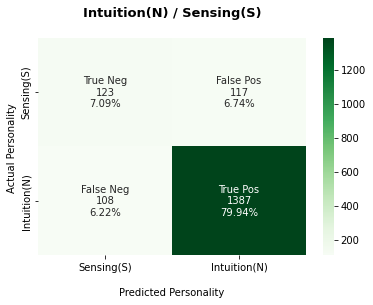


|==================================================================================|



In [ ]:
model = RandomForestClassifier(max_depth = 100,n_estimators=100)
model.fit(X1_train_NS,Y1_train_NS)
pred = model.predict(X1_test_NS)
lpIs = model.predict_proba(X1_test_NS)
com = confusion_matrix(Y1_test_NS,pred)
acc = round(accuracy_score(Y1_test_NS,pred),3)
print("Accuracy for Intuition(N) / Sensing(S): " , 100*acc,"%\n")
print("Classification Report for Intuition(N) / Sensing(S): ", "\n")
print(classification_report(Y1_test_NS,pred,target_names = ["Sensing(S)","Intuition(N)"]))
plot_confusion(com,"Intuition(N) / Sensing(S)",["Sensing(S)","Intuition(N)"],colour="Greens")

Accuracy for Thinking(T), Feeling(F):  80.2 %

Classification Report for Thinking(T), Feeling(F):  

              precision    recall  f1-score   support

  Feeling(F)       0.81      0.82      0.82       939
 Thinking(T)       0.79      0.78      0.78       796

    accuracy                           0.80      1735
   macro avg       0.80      0.80      0.80      1735
weighted avg       0.80      0.80      0.80      1735



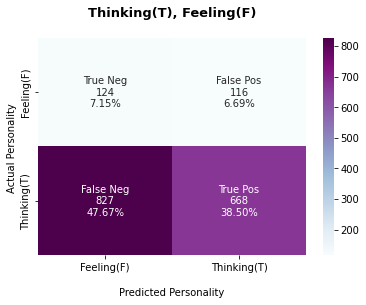


|==================================================================================|



In [ ]:
model = RandomForestClassifier(max_depth = 100,n_estimators=100)
model.fit(X1_train_TF,Y1_train_TF)
pred = model.predict(X1_test_TF)
lpTF = model.predict_proba(X1_test_TF)
com = confusion_matrix(Y1_test_NS,pred)
acc = round(accuracy_score(Y1_test_TF,pred),3)
print("Accuracy for Thinking(T), Feeling(F): " , 100*acc,"%\n")
print("Classification Report for Thinking(T), Feeling(F): ", "\n")
print(classification_report(Y1_test_TF,pred,target_names = ["Feeling(F)","Thinking(T)"]))
plot_confusion(com,"Thinking(T), Feeling(F)",["Feeling(F)","Thinking(T)"],colour="BuPu")

Accuracy for Judging(J), Perceiving(P):  73.6 %

Classification Report for Judging(J), Perceiving(P):  

               precision    recall  f1-score   support

Perceiving(P)       0.78      0.78      0.78      1048
   Judging(J)       0.67      0.67      0.67       687

     accuracy                           0.74      1735
    macro avg       0.72      0.72      0.72      1735
 weighted avg       0.74      0.74      0.74      1735



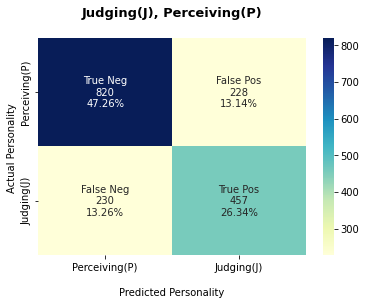


|==================================================================================|



In [ ]:
model = RandomForestClassifier(max_depth = 100,n_estimators=100)
model.fit(X1_train_JP,Y1_train_JP)
pred = model.predict(X1_test_JP)
lpJP = model.predict_proba(X1_test_JP)
com = confusion_matrix(Y1_test_JP,pred)
acc = round(accuracy_score(Y1_test_JP,pred),3)
print("Accuracy for Judging(J), Perceiving(P): " , 100*acc,"%\n")
print("Classification Report for Judging(J), Perceiving(P): ", "\n")
print(classification_report(Y1_test_JP,pred,target_names=["Perceiving(P)","Judging(J)"]))
plot_confusion(com,"Judging(J), Perceiving(P)",["Perceiving(P)","Judging(J)"],colour="YlGnBu")

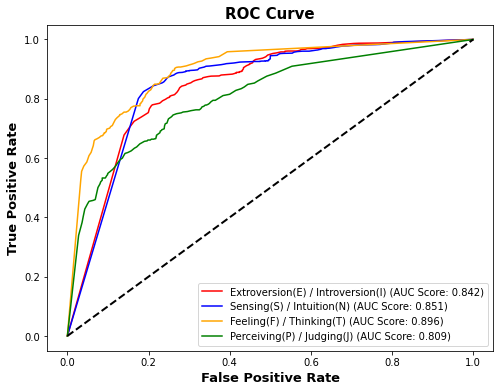

In [ ]:
print_roc_auc_curve(lpIe, lpIs, lpTF, lpJP)